In [ ]:
!sudo apt-get update && sudo apt-get install cmake libopenmpi-dev python3-dev zlib1g-dev
!pip install stable-baselines[mpi]
!pip install stable-baselines3[extra] 'ray[rllib]' hawkeslib

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:6 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:9 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:11 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:12 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:13 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:14 http://security.ubuntu.com/ubuntu bionic-security/universe amd64 Packages [1,39

In [ ]:
import gym
from gym import spaces
import numpy as np
from hawkeslib import UnivariateExpHawkesProcess

np.set_printoptions(suppress=True)

# define model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, LSTM

from numpy import array
from datetime import datetime

import gym
from stable_baselines3 import PPO, DQN, A2C
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)
 

def load_twitter_data():
  df = pd.read_csv('data.csv', header=None)
  tweet_times = np.array([datetime.strptime(s,'%Y-%m-%d %H:%M:%S').timestamp() for s in df[0]])
  t = tweet_times - tweet_times[-1]
  t = t[::-1]
  return t

def load_synthetic_data(max_timestep_value=2000):
  mu, alpha, beta = .1, .3, .1
  uv = UnivariateExpHawkesProcess()
  uv.set_params(mu, alpha, beta)
  points = uv.sample(max_timestep_value)
  return points

In [ ]:
class OptimisEnv(gym.Env):
  def __init__(self):
          self.history = 0 
          self.window_length = 0
          self.num_actions_made = 0
          self.max_allowed_actions = None
          self.num_iterations = 0
          self.action_penalty = 0
          self.time_limit = None

          self.action_space = gym.spaces.Discrete(2)
          self.observation_space = spaces.Box(low=0, high=100,
                                        shape=(1,), dtype=np.float32)

  def set_timestamps(self, data):
    timestamps = data
    self.timestamps = data
          # self.post_times = post_times/self.max_post_time
    self.timestamps_1st_diff = np.diff(self.timestamps)


  
  def display_data_stats(self, points_to_visualize=100):
    
    max_timestamp = max(self.timestamps)
    min_timestamp = min(self.timestamps)

    ts = np.array(self.timestamps)

    top_10_intervals = sorted(np.diff(ts))[::-1][:10]

    total_points = ts.shape[0]

    average_interval_between_points = np.sum(np.diff(ts))/ts.shape[0]

    print('total number of points:', total_points)
    print('max timestamp:', max_timestamp )
    print('min timestamp:', min_timestamp )

    print('average interval between two points:', average_interval_between_points)
    print('Top 10 intervals:', top_10_intervals)

    plt.plot(ts[:points_to_visualize], np.ones_like(ts[:points_to_visualize]) * .1, 'k.')
    plt.show()

  
  def set_constraints(self, max_allowed_actions = None, action_penalty = 0, time_limit = None):
    if time_limit:
      self.time_limit = time_limit
    else:
      self.time_limit = len(self.timestamp)
    if max_allowed_actions:
      self.max_allowed_actions = max_allowed_actions
    
    if action_penalty:
      self.action_penalty = action_penalty

  def settings(self, use_forecaster=False, use_previous_timestamps=False, first_difference=False):
    observation_space_size = 0
    self.use_forecaster = False
    self.use_previous_timestamps = False
    self.first_difference = False

    self.use_forecaster = use_forecaster
    self.use_previous_timestamps = use_previous_timestamps
    self.first_difference = first_difference

    if use_forecaster:
      observation_space_size = 1
      self.use_forecaster = True
    
    if use_previous_timestamps:
      self.use_previous_timestamps = True
      observation_space_size = observation_space_size + self.num_steps


    if first_difference:
      self.first_difference = True
      observation_space_size = observation_space_size + self.num_steps

    self.observation_space = spaces.Box(low=min(self.forecaster_states), high=2*max(self.forecaster_states),
                          shape=(observation_space_size,), dtype=np.float32)


  def train_forecaster(self, num_steps=0, num_epochs=650):
    n_features = 1
    lstm_forecaster = Sequential()
    lstm_forecaster.add(LSTM(50, activation='relu', input_shape=(num_steps, n_features)))
    lstm_forecaster.add(Dense(1))
    lstm_forecaster.compile(optimizer='adam', loss='mse')

    X, y = split_sequence(self.timestamps_1st_diff, num_steps)

    n_features = 1
    X = X.reshape((X.shape[0], X.shape[1], n_features))

    lstm_forecaster.fit(X, y, epochs=num_epochs, verbose=1)
    self.lstm_forecaster = lstm_forecaster

    #create forecaster data
    forecaster_states = []

    for i in range(self.timestamps_1st_diff.shape[0] - num_steps):
      x_input = self.timestamps_1st_diff[i:num_steps+i]
      x_input = x_input.reshape((1, num_steps, n_features))
      yhat = lstm_forecaster.predict(x_input, verbose=0)
      forecaster_states.append(yhat[0][0])

    self.forecaster_states = forecaster_states
    self.num_steps = num_steps
    self.current_step = num_steps

  def add_reward_function(self, rew_func):
    self.reward_function = rew_func


  def step(self, action):
          reward = 0
          done = False
        
          if action == 0:
              reward = 0
          else: 
              reward = self.timestamps[self.current_step+1] - self.timestamps[self.current_step] - self.action_penalty
              self.num_actions_made += 1

              if self.max_allowed_actions:
                if self.num_actions_made >= self.max_allowed_actions:
                  done = True

          if self.current_step == len(self.timestamps) -1 - self.num_steps - self.window_length:    
            done = True
          
          if self.current_step >= self.time_limit:
            done = True

          info = {'current_step': self.current_step, 
                  'current_post_time': self.timestamps[self.current_step],
                  'next_post_time': self.timestamps[self.current_step+1]
                  }

          self.current_step = self.current_step + 1
          self.num_iterations = self.num_iterations + 1



          if self.use_forecaster and self.first_difference:
            state = np.append(self.timestamps_1st_diff[self.num_iterations: self.num_iterations + self.num_steps],
                            self.forecaster_states[self.current_step-self.num_steps])
            
          elif self.use_forecaster and self.use_previous_timestamps:
            state = np.append(self.timestamps[self.num_iterations: self.num_iterations + self.num_steps],
                            self.forecaster_states[self.current_step-self.num_steps])
          
          elif self.use_forecaster:
            state = self.forecaster_states[self.current_step-self.num_steps]

          elif self.first_difference:
            state = self.timestamps_1st_diff[self.num_iterations: self.num_iterations + self.num_steps]

          elif self.use_previous_timestamps:
              state = self.timestamps[self.num_iterations: self.num_iterations + self.num_steps]


          return state, reward, done, info


  def reset(self):
          # self.current_step = self.history
          self.num_actions_made = 0
          self.num_iterations = 0
          self.current_step = self.num_steps
          state = None
          
          if self.use_forecaster and self.first_difference:
            state = np.append(self.timestamps_1st_diff[self.num_iterations: self.num_iterations + self.num_steps],
                            self.forecaster_states[self.current_step-self.num_steps])
            
          elif self.use_forecaster and self.use_previous_timestamps:
            state = np.append(self.timestamps[self.num_iterations: self.num_iterations + self.num_steps],
                            self.forecaster_states[self.current_step-self.num_steps])
          
          elif self.use_forecaster:
            state = self.forecaster_states[self.current_step-self.num_steps]

          elif self.first_difference:
            state = self.timestamps_1st_diff[self.num_iterations: self.num_iterations + self.num_steps]

          elif self.use_previous_timestamps:
              state = self.timestamps[self.num_iterations: self.num_iterations + self.num_steps]


          return state

  def train_agent(self, policy='PPO', iterations=50_000):
    model = None
    
    if policy == 'PPO':
      model = PPO('MlpPolicy', env, verbose=1)
      model.learn(total_timesteps=iterations)
    elif policy == 'DQN':
      model = DQN('MlpPolicy', env, verbose=1)
      model.learn(total_timesteps=iterations)
    elif policy == 'A2C':
      model = A2C('MlpPolicy', env, verbose=1)
      model.learn(total_timesteps=iterations)

    return model


total number of points: 1913
max timestamp: 9169.0
min timestamp: 0.0
average interval between two points: 4.792995295347621
Top 10 intervals: [54.0, 53.0, 49.0, 45.0, 45.0, 43.0, 42.0, 39.0, 39.0, 38.0]


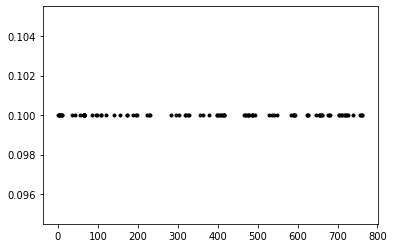

Epoch 1/350
60/60 [==============================] - 6s 43ms/step - loss: 64.2221
Epoch 2/350
60/60 [==============================] - 3s 44ms/step - loss: 43.2316
Epoch 3/350
60/60 [==============================] - 3s 45ms/step - loss: 43.9380
Epoch 4/350
60/60 [==============================] - 3s 43ms/step - loss: 44.3702
Epoch 5/350
60/60 [==============================] - 3s 43ms/step - loss: 39.6918
Epoch 6/350
60/60 [==============================] - 3s 43ms/step - loss: 36.8461
Epoch 7/350
60/60 [==============================] - 3s 45ms/step - loss: 41.4829
Epoch 8/350
60/60 [==============================] - 3s 44ms/step - loss: 38.2747
Epoch 9/350
60/60 [==============================] - 3s 44ms/step - loss: 39.8023
Epoch 10/350
60/60 [==============================] - 3s 45ms/step - loss: 42.5921
Epoch 11/350
60/60 [==============================] - 3s 43ms/step - loss: 42.5770
Epoch 12/350
60/60 [==============================] - 3s 43ms/step - loss: 46.1184
Epoch 13/350


In [ ]:
# loading twitter data
#returns a list of timestamps
data = load_twitter_data()
# data = load_synthetic_data()
#initialise the optimis environment
env = OptimisEnv()

#load the temporal points into the environment
env.set_timestamps(data)

#helper function to display information about the data
env.display_data_stats()

#setting strategies
env.set_constraints(action_penalty=0, 
                    max_allowed_actions=3,
                    time_limit=50)

#train forecaster
env.train_forecaster(num_steps=18, num_epochs=350)

#enable or disable preprocessing techniques
env.settings(use_forecaster=False, 
             use_previous_timestamps=True, 
             first_difference=False)

#training the model
# model = env.train_agent(policy='PPO', iterations=50_000)

In [ ]:
#setting strategies
#unit of time is seconds
env.set_constraints(action_penalty=30, 
                    max_allowed_actions=3,
                    time_limit=3600)

In [ ]:
# env.settings(use_forecaster=True, 
#              use_previous_timestamps=False, 
#              first_difference=False)

total number of points: 1913
max timestamp: 9169.0
min timestamp: 0.0
average interval between two points: 4.792995295347621
Top 10 intervals: [54.0, 53.0, 49.0, 45.0, 45.0, 43.0, 42.0, 39.0, 39.0, 38.0]


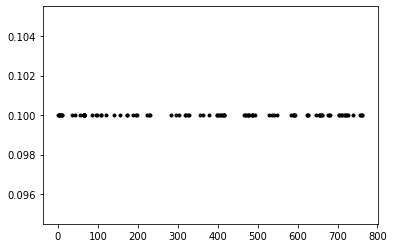

In [ ]:
env.display_data_stats()

In [ ]:
#9169/120
one_hour = 76.40833333333333

In [ ]:
env.set_constraints(action_penalty=0.33*one_hour, 
                    max_allowed_actions=3,
                    time_limit=one_hour*48)

In [ ]:
model = env.train_agent(policy='PPO', iterations=200_000)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 5.96      |
|    ep_rew_mean          | -47.9     |
| time/                   |           |
|    fps                  | 620       |
|    iterations           | 1         |
|    time_elapsed         | 3         |
|    total_timesteps      | 2048      |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -5.26e-05 |
|    explained_variance   | -0.0325   |
|    learning_rate        | 0.0003    |
|    loss                 | 4.3e-07   |
|    n_updates            | 980       |
|    policy_gradient_loss | -4.46e-08 |
|    value_loss           | 2.68e-06  |
---------------------------------------
----------------------------------------
| rollout/              

In [ ]:
def evaluate(model, num_steps=10000):
  episode_rewards = [0.0]
  obs = env.reset()

  print(obs)
  total_post_time = 0
  total_posts_made = 0

  for i in range(num_steps):
      
      action, _states = model.predict([obs])

      obs, reward, done, info = env.step(action)

      if action==1:
        print(info)
        print('reward:', reward)

        post_time = info['next_post_time'] - info['current_post_time']

        total_post_time += post_time
        total_posts_made += 1

      
      # Stats
      episode_rewards[-1] += reward
      if done:
          print('episode end\n\n\n')
          obs = env.reset()
          episode_rewards.append(0.0)
  # Compute mean reward for the last 100 episodes
  mean_100ep_reward = np.mean(episode_rewards)
  print("Mean reward:", mean_100ep_reward, "Num episodes:", len(episode_rewards))
  
  return mean_100ep_reward, total_post_time, total_posts_made

mean_reward, total_post_time, total_posts_made = evaluate(model, num_steps=10000)
print(mean_reward, total_post_time, total_posts_made)
print('mean time per post:', total_post_time/total_posts_made)

[ 0.  3.  3.  4.  5.  7. 10. 11. 36. 42. 55. 65. 65. 65. 65. 65. 65. 65.]
episode end



episode end



episode end



episode end



episode end



Mean reward: 0.0 Num episodes: 6
0.0 0 0


ZeroDivisionError: ignored

In [ ]:
45.4559748427673*60/76.40


35.69840956238269

In [ ]:
env.timestamps

array([   0.,    3.,    3., ..., 9162., 9169., 9169.])

In [ ]:
np.diff(env.timestamps[:10])


array([ 3.,  0.,  1.,  1.,  2.,  3.,  1., 25.,  6.])

In [ ]:
bins =  np.arange(0, 9169, 100)
ind = np.digitize(env.timestamps, bins)

In [ ]:
ind

array([ 1,  1,  1, ..., 92, 92, 92])

In [ ]:
u = numpy.unique(ind)

In [ ]:
u

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
       86, 87, 88, 89, 90, 91, 92])

In [ ]:
import collections, numpy
a = ind
coll = collections.Counter(a)

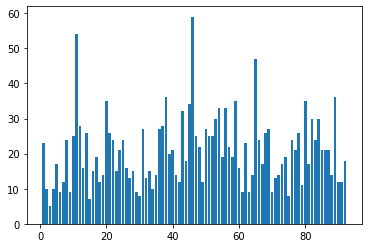

In [ ]:
import collections
import matplotlib.pyplot as plt
l = env.timestamps
w = coll
plt.bar(w.keys(), w.values())
plt.savefig("bar.png", dpi=300)